## 6.1 Ablation Experiments

### 6.1.1 The effect of non-stationary spectral kernels

In [1]:
%%bash
python3 exp_ablation0_RFFNet.py
python3 exp_ablation0_DSKN.py

Process is terminated.


In [1]:
import torch
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from models import train, test

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose(
    [transforms.ToTensor(), 
    transforms.Normalize((0.1307,), (0.3081,))])

trainloader = torch.utils.data.DataLoader(datasets.MNIST(root='./data', train=True, download=True, transform=transform), batch_size=20000, shuffle=False)

dataiter = iter(trainloader)
images, labels = dataiter.next()
indices = torch.concat(((labels == 4).nonzero()[:1000].view(-1), (labels == 9).nonzero()[:1000].view(-1)))
# _, indices = labels.sort()

with torch.no_grad():
    checkpoint_RFFNet = torch.load('./results/exp_ablation0_RFFNet.pt')
    model = checkpoint_RFFNet['model']
    feature_mapping, _ = model(images[indices].to(device))
    rff_kernel = feature_mapping @ feature_mapping.T
    f = plt.figure()
    plt.imshow(rff_kernel.cpu().detach().numpy())
    plt.colorbar()
    plt.title('Stationary Spectral Kernel')
    plt.xlabel('x')
    plt.ylabel('x\'')
    f.savefig('./results/exp_ablation0_RFFNet.pdf', bbox_inches='tight')

    checkpoint_DSKN = torch.load('./results/exp_ablation0_DSKN.pt')
    model = checkpoint_DSKN['model']
    feature_mapping, _ = model(images[indices].to(device))
    ns_kernel = feature_mapping @ feature_mapping.T
    f = plt.figure()
    plt.imshow(ns_kernel.cpu().detach().numpy())
    plt.colorbar()
    plt.title('Non-stationary Spectral Kernel')
    plt.xlabel('x')
    plt.ylabel('x\'')    
    f.savefig('./results/exp_ablation0_DSKN.pdf', bbox_inches='tight')

    f = plt.figure()
    plt.plot(rff_kernel.diag().cpu().numpy())
    plt.plot(ns_kernel.diag().cpu().numpy())
    plt.ylim(0, 1.2)
    plt.xlabel('x')
    plt.ylabel('$\kappa(x, x)$')
    plt.legend(['stationary spectral kernel', 'non-stationary spectral kernel'])
    plt.title('Diagonal Elements of Kernel Matrix')
    f.savefig('./results/exp_ablation0_diagonal.pdf', bbox_inches='tight')

    f = plt.figure()
    eigvalues_rff, _ = torch.linalg.eig(rff_kernel)
    eigvalues_ns, _ = torch.linalg.eig(ns_kernel)
    plt.xlabel('Descending number')
    plt.ylabel('Eigenvalues')
    plt.plot(eigvalues_rff.cpu().numpy()[:10])
    plt.plot(eigvalues_ns.cpu().numpy()[:10])
    plt.legend(['stationary spectral kernel', 'non-stationary spectral kernel'])
    plt.title('Eigenvalues of Kernel Matrix')
    f.savefig('./results/exp_ablation0_eig.pdf', bbox_inches='tight')

    print('Average distance for stationary spectral kernel: {:.5f}'.format((rff_kernel[:1000,:1000].mean() + rff_kernel[1000:,1000:].mean() - rff_kernel[:1000,1000:].mean() - rff_kernel[1000:,:1000].mean()).item()))
    print('Average distance for non-stationary spectral kernel: {:.5f}'.format(ns_kernel[:1000,:1000].mean() + ns_kernel[1000:,1000:].mean() -ns_kernel[:1000,1000:].mean() - ns_kernel[1000:,:1000].mean()))

    f = plt.figure()
    plt.plot(checkpoint_RFFNet['RFFNet_accuracy'])
    plt.plot(checkpoint_DSKN['DSKN_accuracy'])
    plt.xlabel('# Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend(['stationary spectral kernel', 'non-stationary spectral kernel'])
    plt.title('Test Accuracy')

In [9]:
model

RFFNet(
  (op_list): ModuleList(
    (0): Linear(in_features=784, out_features=2000, bias=True)
  )
  (fc_out): Linear(in_features=2000, out_features=10, bias=True)
)

### 6.1.2 The effect of multiple layers

In [ ]:
%%bash
python3 exp_ablation1_layers.py --num_layers 1
python3 exp_ablation1_layers.py --num_layers 2
python3 exp_ablation1_layers.py --num_layers 3
python3 exp_ablation1_layers.py --num_layers 4
python3 exp_ablation1_layers.py --num_layers 5

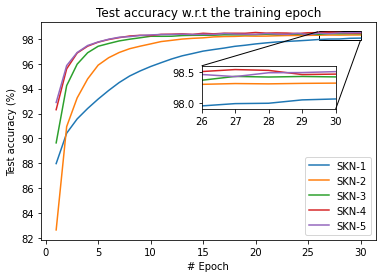

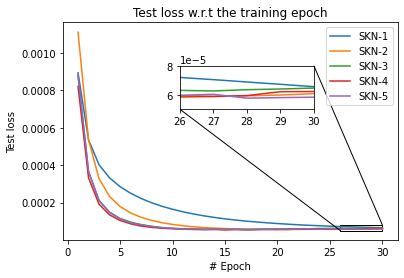

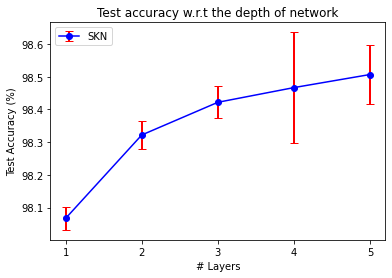

In [28]:
import torch
import numpy as np
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import matplotlib.pyplot as plt

checkpoint_1layers = torch.load('./results/exp_ablation1_1layers.pt')
checkpoint_2layers = torch.load('./results/exp_ablation1_2layers.pt')
checkpoint_3layers = torch.load('./results/exp_ablation1_3layers.pt')
checkpoint_4layers = torch.load('./results/exp_ablation1_4layers.pt')
checkpoint_5layers = torch.load('./results/exp_ablation1_5layers.pt')

f, ax = plt.subplots(1, 1, figsize=(6, 4))
plt.plot(range(1, 31), checkpoint_1layers['test_acc_arr'].mean(0))
plt.plot(range(1, 31), checkpoint_2layers['test_acc_arr'].mean(0))
plt.plot(range(1, 31), checkpoint_3layers['test_acc_arr'].mean(0))
plt.plot(range(1, 31), checkpoint_4layers['test_acc_arr'].mean(0))
plt.plot(range(1, 31), checkpoint_5layers['test_acc_arr'].mean(0))
plt.legend(['DSKN-1', 'DSKN-2', 'DSKN-3', 'DSKN-4', 'DSKN-5'])
plt.xlabel('# Epoch')
plt.ylabel('Test accuracy (%)')
plt.title('Test accuracy w.r.t the training epoch')
axins = ax.inset_axes((0.48, 0.6, 0.4, 0.2))
axins.plot(range(1, 31), checkpoint_1layers['test_acc_arr'].mean(0))
axins.plot(range(1, 31), checkpoint_2layers['test_acc_arr'].mean(0))
axins.plot(range(1, 31), checkpoint_3layers['test_acc_arr'].mean(0))
axins.plot(range(1, 31), checkpoint_4layers['test_acc_arr'].mean(0))
axins.plot(range(1, 31), checkpoint_5layers['test_acc_arr'].mean(0))
axins.set_xlim(26, 30)
axins.set_ylim(97.9, 98.6)
mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec='k', lw=1)
plt.show()
f.savefig('./results/exp_ablation1_acc_epoch.pdf', bbox_inches='tight')

f, ax = plt.subplots(1, 1, figsize=(6, 4))
plt.plot(range(1, 31), checkpoint_1layers['loss_arr'].mean(0))
plt.plot(range(1, 31), checkpoint_2layers['loss_arr'].mean(0))
plt.plot(range(1, 31), checkpoint_3layers['loss_arr'].mean(0))
plt.plot(range(1, 31), checkpoint_4layers['loss_arr'].mean(0))
plt.plot(range(1, 31), checkpoint_5layers['loss_arr'].mean(0))
axins = ax.inset_axes((0.35, 0.6, 0.4, 0.2))
axins.plot(range(1, 31), checkpoint_1layers['loss_arr'].mean(0))
axins.plot(range(1, 31), checkpoint_2layers['loss_arr'].mean(0))
axins.plot(range(1, 31), checkpoint_3layers['loss_arr'].mean(0))
axins.plot(range(1, 31), checkpoint_4layers['loss_arr'].mean(0))
axins.plot(range(1, 31), checkpoint_5layers['loss_arr'].mean(0))
axins.set_xlim(26, 30)
axins.set_ylim(0.00005, 0.00008)
mark_inset(ax, axins, loc1=3, loc2=1, fc="none", ec='k', lw=1)
plt.legend(['DSKN-1', 'DSKN-2', 'DSKN-3', 'DSKN-4', 'DSKN-5'])
plt.xlabel('# Epoch')
plt.ylabel('Test loss')
plt.title('Test loss w.r.t the training epoch')
plt.show()
f.savefig('./results/exp_ablation1_loss_epoch.pdf', bbox_inches='tight')

test_acc_final = np.array([checkpoint_1layers['test_acc_arr'][:, 29], checkpoint_2layers['test_acc_arr'][:, 29], checkpoint_3layers['test_acc_arr'][:, 29], checkpoint_4layers['test_acc_arr'][:, 29], checkpoint_5layers['test_acc_arr'][:, 29]])

f = plt.figure()
# plt.plot(range(1, 6), test_acc_final.mean(1))
plt.errorbar(range(1, 6), test_acc_final.mean(1), test_acc_final.std(1), fmt='-o',ecolor='r',color='b',elinewidth=2,capsize=4)
plt.legend(['SKN'])
plt.xlabel('# Layers')
plt.xticks(range(1, 6))
plt.ylabel('Test Accuracy (%)')
plt.title('Test accuracy w.r.t the depth of network')
plt.show()
f.savefig('./results/exp_ablation1_acc_layers.pdf', bbox_inches='tight')

[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.ModuleList'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'models.DSKN'>. Treat it as zero Macs and zero Params.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.ModuleList'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'models.DSKN'>. Treat it as zero Macs and zero Params.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.ModuleList'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'models.DSKN'>. Treat it as zero Macs and zero Params.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.ModuleList'

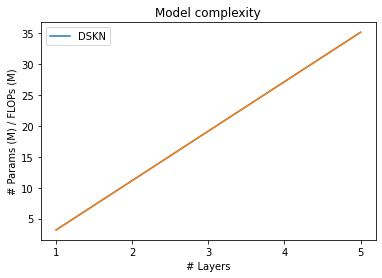

In [3]:
from models import DSKN, CSKN
import matplotlib.pyplot as plt
import torch
from thop import profile

growth_factor = [None, 1, 32, 16, 10, 7]
lr0 = 1e-4
lr1 = 1e-4
sigma0 = 1e-2
sigma1 = 1e-2

FLOPs_arr = []
Params_arr = []
for num_layers in range(1, 6):
    model = DSKN(784, [2000 for _ in range(num_layers)], 10, sigma0, sigma1, growth_factor[num_layers], True)
    input = torch.randn(1, 28, 28)
    flops, params = profile(model, inputs = (input, ))
    FLOPs_arr.append(flops/1000**2)
    Params_arr.append(params/1000**2)

print(FLOPs_arr)
print(Params_arr)

f = plt.figure()
plt.plot(range(1, 6), Params_arr)
plt.plot(range(1, 6), FLOPs_arr)
plt.legend(['DSKN'])
plt.xlabel('# Layers')
plt.xticks(range(1, 6))
plt.ylabel('# Params (M) / FLOPs (M)')
plt.title('Model complexity')
plt.show()
f.savefig('./results/exp_ablation1_complexity.pdf', bbox_inches='tight')

In [4]:
from torchstat import stat
from models import VanillaCNNNet, DNN, DSKN, CSKN

num_layers = 5
growth_factor = [None, 1, 32, 16, 10, 7]
lr0 = 1e-4
lr1 = 1e-4
sigma0 = 1e-2
sigma1 = 1e-2
growth_factor = [None, 1, 32, 16, 10, 7]

stat(DSKN(784, [2000 for _ in range(num_layers)], 10, sigma0, sigma1, growth_factor[num_layers], True), (1, 28, 28))

num_layers = 2
stat(DSKN(784, [2000 for _ in range(num_layers)], 10, sigma0, sigma1, growth_factor[num_layers], True), (1, 28, 28))

      module name input shape output shape      params memory(MB)          MAdd         Flops  MemRead(B)  MemWrite(B) duration[%]    MemR+W(B)
0      op_list0.0         784         2000   1570000.0       0.01   3,134,000.0   1,568,000.0   6275136.0       8000.0       6.47%    6283136.0
1      op_list0.1        2000         2000   4002000.0       0.01   7,998,000.0   4,000,000.0  16008000.0       8000.0       8.34%   16016000.0
2      op_list0.2        2000         2000   4002000.0       0.01   7,998,000.0   4,000,000.0  16008000.0       8000.0       7.39%   16016000.0
3      op_list0.3        2000         2000   4002000.0       0.01   7,998,000.0   4,000,000.0  16008000.0       8000.0      11.28%   16016000.0
4      op_list0.4        2000         2000   4002000.0       0.01   7,998,000.0   4,000,000.0  16008000.0       8000.0       9.41%   16016000.0
5      op_list1.0         784         2000   1570000.0       0.01   3,134,000.0   1,568,000.0   6275136.0       8000.0      13.99%    62

### 6.1.3 The effect of regularizers

In [ ]:
%%bash
python3 exp_ablation2_regularizers.py

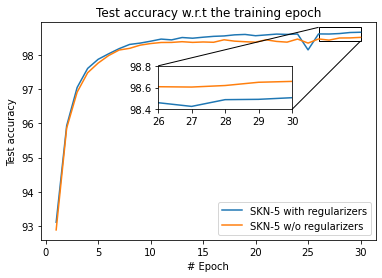

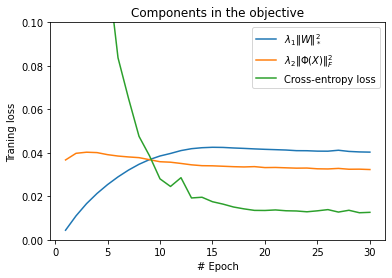

In [66]:
import torch
import numpy as np
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import matplotlib.pyplot as plt

checkpoint_unregulerized = torch.load('./results/exp_ablation1_5layers.pt')
checkpoint_regulerized = torch.load('./results/exp_ablation2_regularizers.pt')

f, ax = plt.subplots(1, 1, figsize=(6, 4))
plt.plot(range(1, 31), checkpoint_regulerized['test_acc_arr'].mean(0))
plt.plot(range(1, 31), checkpoint_unregulerized['test_acc_arr'].mean(0))
axins = ax.inset_axes((0.35, 0.6, 0.4, 0.2))
axins.plot(range(1, 31), checkpoint_unregulerized['test_acc_arr'].mean(0))
axins.plot(range(1, 31), checkpoint_regulerized['test_acc_arr'].mean(0))
axins.set_xlim(26, 30)
axins.set_ylim(98.4, 98.8)
mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec='k', lw=1)
plt.legend(['SKN-5 with regularizers', 'SKN-5 w/o regularizers'])
plt.xlabel('# Epoch')
plt.ylabel('Test accuracy')
plt.title('Test accuracy w.r.t the training epoch')
plt.show()
f.savefig('./results/exp_ablation2_acc_epoch.pdf', bbox_inches='tight')

f, ax = plt.subplots(1, 1, figsize=(6, 4))
# plt.plot(range(1, 31), checkpoint_unregulerized['reg_features_arr'].mean(0))
plt.plot(range(1, 31), checkpoint_regulerized['reg_weights_arr'].mean(0))
plt.plot(range(1, 31), checkpoint_regulerized['reg_features_arr'].mean(0))
plt.plot(range(1, 31), checkpoint_regulerized['loss_arr'].mean(0))
plt.ylim(0, 0.1)
plt.legend(['$\lambda_1 \Vert W \Vert_*^2$', '$\lambda_2 \Vert \Phi(X) \Vert_F^2$', 'Cross-entropy loss'])
plt.xlabel('# Epoch')
plt.ylabel('Traning loss')
plt.title('Components in the objective')
plt.show()
f.savefig('./results/exp_ablation2_trace_epoch.pdf', bbox_inches='tight')

### 6.1.4 The effect of convolutional filters

In [ ]:
%%bash
python3 exp_ablation3_convolutional.py --kernel_size 3
python3 exp_ablation3_convolutional.py --kernel_size 5
python3 exp_ablation3_convolutional.py --kernel_size 7

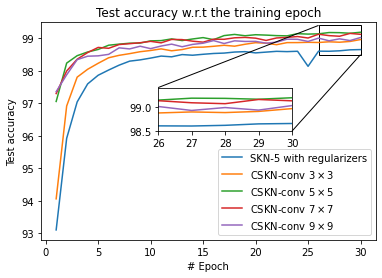

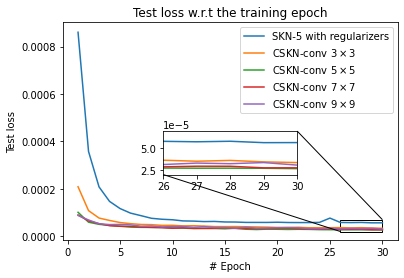

In [3]:
import torch
import numpy as np
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import matplotlib.pyplot as plt

checkpoint_regulerized = torch.load('./results/exp_ablation2_regularizers.pt')
checkpoint_conv3 = torch.load('./results/exp_ablation3_convolutional3.pt')
checkpoint_conv5 = torch.load('./results/exp_ablation3_convolutional5.pt')
checkpoint_conv7 = torch.load('./results/exp_ablation3_convolutional7.pt')
checkpoint_conv9 = torch.load('./results/exp_ablation3_convolutional9.pt')

f, ax = plt.subplots(1, 1, figsize=(6, 4))
plt.plot(range(1, 31), checkpoint_regulerized['test_acc_arr'].mean(0))
plt.plot(range(1, 31), checkpoint_conv3['test_acc_arr'].mean(0))
plt.plot(range(1, 31), checkpoint_conv5['test_acc_arr'].mean(0))
plt.plot(range(1, 31), checkpoint_conv7['test_acc_arr'].mean(0))
plt.plot(range(1, 31), checkpoint_conv9['test_acc_arr'].mean(0))
axins = ax.inset_axes((0.35, 0.5, 0.4, 0.2))
axins.plot(range(1, 31), checkpoint_regulerized['test_acc_arr'].mean(0))
axins.plot(range(1, 31), checkpoint_conv3['test_acc_arr'].mean(0))
axins.plot(range(1, 31), checkpoint_conv5['test_acc_arr'].mean(0))
axins.plot(range(1, 31), checkpoint_conv7['test_acc_arr'].mean(0))
axins.plot(range(1, 31), checkpoint_conv9['test_acc_arr'].mean(0))
axins.set_ylim(98.5, 99.4)
axins.set_xlim(26, 30)
mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec='k', lw=1)
plt.legend(['SKN-5 with regularizers', 'CSKN-conv $3 \\times 3$', 'CSKN-conv $5 \\times 5$', 'CSKN-conv $7 \\times 7$', 'CSKN-conv $9 \\times 9$'])
plt.xlabel('# Epoch')
plt.ylabel('Test accuracy')
plt.title('Test accuracy w.r.t the training epoch')
plt.show()
f.savefig('./results/exp_ablation3_acc_epoch.pdf', bbox_inches='tight')

f, ax = plt.subplots(1, 1, figsize=(6, 4))
plt.plot(range(1, 31), checkpoint_regulerized['test_loss_arr'].mean(0))
plt.plot(range(1, 31), checkpoint_conv3['test_loss_arr'].mean(0))
plt.plot(range(1, 31), checkpoint_conv5['test_loss_arr'].mean(0))
plt.plot(range(1, 31), checkpoint_conv7['test_loss_arr'].mean(0))
plt.plot(range(1, 31), checkpoint_conv9['test_loss_arr'].mean(0))
axins = ax.inset_axes((0.3, 0.3, 0.4, 0.2))
axins.plot(range(1, 31), checkpoint_regulerized['test_loss_arr'].mean(0))
axins.plot(range(1, 31), checkpoint_conv3['test_loss_arr'].mean(0))
axins.plot(range(1, 31), checkpoint_conv5['test_loss_arr'].mean(0))
axins.plot(range(1, 31), checkpoint_conv7['test_loss_arr'].mean(0))
axins.plot(range(1, 31), checkpoint_conv9['test_loss_arr'].mean(0))
axins.set_ylim(2e-5, 7e-5)
axins.set_xlim(26, 30)
mark_inset(ax, axins, loc1=3, loc2=1, fc="none", ec='k', lw=1)
plt.legend(['SKN-5 with regularizers', 'CSKN-conv $3 \\times 3$', 'CSKN-conv $5 \\times 5$', 'CSKN-conv $7 \\times 7$', 'CSKN-conv $9 \\times 9$'])
plt.xlabel('# Epoch')
plt.ylabel('Test loss')
plt.title('Test loss w.r.t the training epoch')
plt.show()
f.savefig('./results/exp_ablation3_loss_epoch.pdf', bbox_inches='tight')


In [6]:
from models import VanillaCNNNet, DNN, DSKN, CSKN
import matplotlib.pyplot as plt
import torch
from thop import profile


sigma0 = 1e-2
sigma1 = 1e-2
growth_factor = 7

FLOPs_arr_CSKN = []
Params_arr_CSKN = []
for kernel_size in [3, 5, 7, 9]:
    print(kernel_size)
    model = CSKN(784, 10, 1, 20, 5, kernel_size, sigma0, sigma1, growth_factor, True)
    input = torch.randn(1, 1, 28, 28)
    flops, params = profile(model, inputs = (input, ))
    FLOPs_arr_CSKN.append(flops/1000**2)
    Params_arr_CSKN.append(params/1000**2)
    
print('CSKN --- FLOPs: {} M'.format(FLOPs_arr_CSKN))
print('CSKN --- # Params: {} M'.format(Params_arr_CSKN))

model = DSKN(784, [2000 for _ in range(5)], 10, sigma0, sigma1, growth_factor, True)
input = torch.randn(1, 28, 28)
flops, params = profile(model, inputs = (input, ))
print('DSKN --- FLOPs: {} M'.format(flops/1000**2))
print('DSKN --- # Params: {} M'.format(params/1000**2))

3
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.ModuleList'>. Treat it as zero Macs and zero Params.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[WARN] Cannot find rule for <class 'models.CSKN'>. Treat it as zero Macs and zero Params.
5
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.ModuleList'>. Treat it as zero Macs and zero Params.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[WARN] Cannot find rule for <class 'models.CSKN'>. Treat it as zero Macs and zero Params.
7
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.ModuleList'>. Treat it as zero Macs and zero Params.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[WARN] Can

In [4]:
print(checkpoint_conv3['test_acc_arr'][:, -1].mean())
print(checkpoint_conv5['test_acc_arr'][:, -1].mean())
print(checkpoint_conv7['test_acc_arr'][:, -1].mean())
print(checkpoint_conv9['test_acc_arr'][:, -1].mean())

98.96499999999999
99.19000000000001
99.126
99.02799999999999
